<a href="https://colab.research.google.com/github/farshad36/STGN/blob/main/stgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d fmena14/crowd-counting

Dataset URL: https://www.kaggle.com/datasets/fmena14/crowd-counting
License(s): unknown
100% 1.17G/1.18G [00:13<00:00, 87.4MB/s]
100% 1.18G/1.18G [00:13<00:00, 91.7MB/s]


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/crowd-counting.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/stgn')  # Replace 'destination_folder' with your desired folder

In [ ]:
import numpy as np
X = np.load("/content/drive/MyDrive/stgn/images.npy")
y = np.load("/content/drive/MyDrive/stgn/labels.npy")

In [ ]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/stgn')
# Import the module


In [ ]:
import os, cv2
import pdb
import numpy as np
import scipy.io
from skimage import io
import skimage.transform as SkT
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

import np_transforms as NP_T
from utils import density_map, gaussian_filter_density
from scipy.ndimage.filters import gaussian_filter

<ipython-input-4-9d3cb9762e29>:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
y.shape

(2000, 1)

In [ ]:
X.shape

(2000, 480, 640, 3)

In [ ]:
random_numbers

array([157, 589])

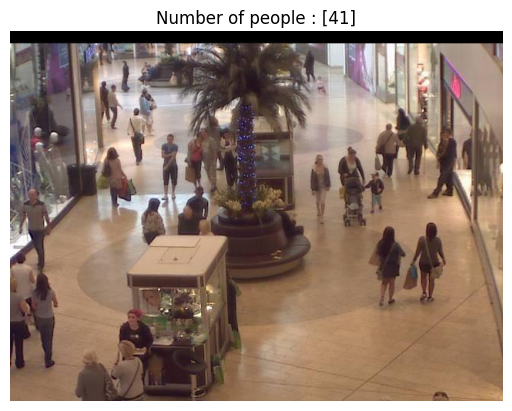

In [ ]:
# Generate 5 random numbers within the range
random_numbers = np.random.randint(0, len(X), size=2)
random_numbers=[1]
# Display the images corresponding to the random numbers
for number in random_numbers:
    image = X[number]
    plt.imshow(image)
    plt.title(f"Number of people : {y[number]}")
    plt.axis('off')
    plt.show()


# Classess

In [ ]:
class TestDataset(Dataset):
    def __init__(self,
                 train,
                 path,
                 out_shape=None,
                 transform=None,
                 gamma=5,
                 max_len=None,
                 adaptive=False,
                 k_nearest=3,
                 load_all=False):
        self.k = k_nearest
        self.adaptive = adaptive
        self.path = path
        self.out_shape = np.array(out_shape)
        self.transform = transform
        self.gamma = gamma
        self.load_all = load_all

        if train:
            self.img_path = os.path.join(self.path, 'train_data')
            self.label_path = os.path.join(self.path, 'train_label')
        else:
            self.img_path = os.path.join(self.path, 'test_data')
            self.label_path = os.path.join(self.path, 'test_label')

        dirs = os.listdir(self.img_path)
        self.image_files = []
        for dir_name in dirs:
            self.image_files += [
                '{}&{}'.format(dir_name, f)
                for f in os.listdir(os.path.join(self.img_path, dir_name))
                if f.endswith('png') or f.endswith('jpg')
            ]

        if self.load_all:
            self.images, self.gts = [], []
            for img_f in self.image_files:
                X, gt = self.load_example(img_f)
                self.images.append(X)
                self.gts.append(gt)

    def load_example(self, img_f):
        dir_name, img_name = img_f.split('&')
        # img = Image.open(os.path.join(self.img_path, dir_name, img_name)).convert('RGB')
        img = cv2.imread(os.path.join(self.img_path, dir_name, img_name))
#         if len(img.shape) == 2:
#             print(os.path.join(self.img_path, dir_name, img_name))
        points = y#np.load(os.path.join(self.label_path, dir_name, img_name[:-4]+ '.npy'))
        H_orig, W_orig = img.shape[:2]
        if H_orig != self.out_shape[0] or W_orig != self.out_shape[1]:
            # img = img.resize((self.out_shape[1], self.out_shape[0]), Image.BILINEAR)
            img = cv2.resize(img, (self.out_shape[1], self.out_shape[0]), cv2.INTER_LINEAR)
            ratio = self.out_shape / np.array([H_orig, W_orig])
            points = np.round(points*ratio)
        img = np.array(img, np.float32)
        points = np.array(points, np.int32)
        points = np.minimum(points, self.out_shape - 1)
        gt = np.zeros(self.out_shape)
        gt[points[:, 0], points[:, 1]] = 1

        gt = gt[:, :, np.newaxis].astype('float32')
        return img, gt

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, i):
        if self.load_all:
            img_f = self.image_files[i]
            X = self.images[i]
            gt = self.gts[i]
        else:
            img_f = self.image_files[i]
            X, gt = self.load_example(img_f)

        if self.transform:
            X, gt = self.transform([X, gt])

        return X, gt, img_f


In [ ]:
class TestSeq(TestDataset):
    def __init__(self,
                 train=True,
                 path='../ucsdpeds/UCSD',
                 out_shape=[240, 320],
                 transform=None,
                 gamma=5,
                 adaptive=False,
                 k_nearest=3,
                 max_len=None,
                 load_all=False):
        super(TestSeq, self).__init__(train=train,
                                       path=path,
                                       out_shape=out_shape,
                                       transform=transform,
                                       gamma=gamma,
                                       adaptive=adaptive,
                                       k_nearest=k_nearest,
                                       max_len=max_len,
                                       load_all=load_all)

        self.img2idx = {img: idx for idx, img in enumerate(self.image_files)}
        self.seqs = []
        prev_dir = None
        cur_len = 0
        for img_f in self.image_files:
            dir_name, img_name = img_f.split('&')
            if (dir_name == prev_dir) and ((max_len is None) or
                                           (cur_len < max_len)):
                self.seqs[-1].append(img_f)
                cur_len += 1
            else:
                self.seqs.append([img_f])
                cur_len = 1
                prev_dir = dir_name

        if max_len is None:
            self.max_len = max([len(seq) for seq in self.seqs])
        else:
            self.max_len = max_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, i):
        seq = self.seqs[i]
        seq_len = len(seq)

        # randomize the (random) transformations applied to the first image of the sequence
        # and then apply the same transformations to the remaining images of the sequence
        if isinstance(self.transform, T.Compose):
            for transf in self.transform.transforms:
                if hasattr(transf, 'rand_state'):
                    transf.reset_rand_state()
        elif hasattr(self.transform, 'rand_state'):
            self.transform.reset_rand_state()

        # build the sequences
        X = torch.zeros(self.max_len, 3, self.out_shape[0], self.out_shape[1])
        gt = torch.zeros(self.max_len, 1, self.out_shape[0], self.out_shape[1])
        names = []
        for j, img_f in enumerate(seq):
            idx = self.img2idx[img_f]
            X[j], gt[j], name = super().__getitem__(idx)
            names.append(name)

        return X, gt, seq_len, names



In [ ]:
class CrowdDataset(Dataset):
    def __init__(self,
                 train,
                 path,
                 out_shape=None,
                 transform=None,
                 gamma=5,
                 max_len=None,
                 adaptive=False,
                 k_nearest=3,
                 load_all=False):
        self.k = k_nearest
        self.adaptive = adaptive
        self.path = path
        self.out_shape = np.array(out_shape)
        self.transform = transform
        self.gamma = gamma
        self.load_all = load_all

        if train:
            self.img_path = os.path.join(self.path, 'train_data')
            self.label_path = os.path.join(self.path, 'train_label')
        else:
            self.img_path = os.path.join(self.path, 'test_data')
            self.label_path = os.path.join(self.path, 'test_label')

        dirs = os.listdir(self.img_path)
        self.image_files = []
        for dir_name in dirs:
            self.image_files += [
                '{}&{}'.format(dir_name, f)
                for f in os.listdir(self.img_path)#os.path.join(self.img_path, dir_name))
                if f.endswith('png') or f.endswith('jpg')
            ]

        if self.load_all:
            self.images, self.gts, self.densities = [], [], []
            for img_f in self.image_files:
                X, density, gt = self.load_example(img_f)
                self.images.append(X)
                self.densities.append(density)
                self.gts.append(gt)

    def load_example(self, img_f):
        dir_name, img_name = img_f.split('&')
        # img = Image.open(os.path.join(self.img_path, dir_name, img_name)).convert('RGB')
        img = cv2.imread(os.path.join(self.img_path, dir_name))
#         if len(img.shape) == 2:
#             print(os.path.join(self.img_path, dir_name, img_name))
        points = y#np.load(os.path.join(self.label_path, dir_name, img_name[:-4]+ '.npy'))

        H_orig, W_orig = img.shape[:2]
        if H_orig != self.out_shape[0] or W_orig != self.out_shape[1]:
            # img = img.resize((self.out_shape[1], self.out_shape[0]), Image.BILINEAR)
            img = cv2.resize(img, (self.out_shape[1], self.out_shape[0]), cv2.INTER_LINEAR)
            ratio = self.out_shape / np.array([H_orig, W_orig])
            points = np.round(points*ratio)
        img = np.array(img, np.float32)
        points = np.array(points, np.int32)
        points = np.minimum(points, self.out_shape - 1)
        gt = np.zeros(self.out_shape)
        gt[points[:, 0], points[:, 1]] = 1

        density = gaussian_filter_density(gt, self.gamma, self.k, self.adaptive)
        density = cv2.resize(density, (density.shape[1] // 8, density.shape[0] // 8),
                             interpolation=cv2.INTER_LINEAR) * 64
        density = density[:, :, np.newaxis].astype('float32')
        gt = gt[:, :, np.newaxis].astype('float32')
        return img, density, gt

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, i):
        if self.load_all:
            img_f = self.image_files[i]
            X = self.images[i]
            density = self.densities[i]
            gt = self.gts[i]
        else:
            img_f = self.image_files[i]
            X, density, gt = self.load_example(img_f)

        if self.transform:
            X, density, gt = self.transform([X, density, gt])

        return X, density, gt



In [ ]:
class CrowdSeq(CrowdDataset):
    def __init__(self,
                 train=True,
                 path='../ucsdpeds/UCSD',
                 out_shape=[240, 320],
                 transform=None,
                 gamma=5,
                 adaptive=False,
                 k_nearest=3,
                 max_len=None,
                 load_all=False):
        super(CrowdSeq, self).__init__(train=train,
                                       path=path,
                                       out_shape=out_shape,
                                       transform=transform,
                                       gamma=gamma,
                                       adaptive=adaptive,
                                       k_nearest=k_nearest,
                                       max_len=max_len,
                                       load_all=load_all)

        self.img2idx = {img: idx for idx, img in enumerate(self.image_files)}
        self.seqs = []
        prev_dir = None
        cur_len = 0
        for img_f in self.image_files:
            dir_name, img_name = img_f.split('&')
            if (dir_name == prev_dir) and ((max_len is None) or
                                           (cur_len < max_len)):
                self.seqs[-1].append(img_f)
                cur_len += 1
            else:
                self.seqs.append([img_f])
                cur_len = 1
                prev_dir = dir_name

        if max_len is None:
            self.max_len = max([len(seq) for seq in self.seqs])
        else:
            self.max_len = max_len

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, i):
        seq = self.seqs[i]
        seq_len = len(seq)

        # randomize the (random) transformations applied to the first image of the sequence
        # and then apply the same transformations to the remaining images of the sequence
        if isinstance(self.transform, T.Compose):
            for transf in self.transform.transforms:
                if hasattr(transf, 'rand_state'):
                    transf.reset_rand_state()
        elif hasattr(self.transform, 'rand_state'):
            self.transform.reset_rand_state()

        # build the sequences
        X = torch.zeros(self.max_len, 3, self.out_shape[0], self.out_shape[1])
        density = torch.zeros(self.max_len, 1, self.out_shape[0]//8,
                              self.out_shape[1]//8)
        gt = torch.zeros(self.max_len, 1, self.out_shape[0], self.out_shape[1])
        for j, img_f in enumerate(seq):
            idx = self.img2idx[img_f]
            X[j], density[j], gt[j] = super().__getitem__(idx)

        return X, density, gt, seq_len



# New Section

In [ ]:
if __name__ == '__main__':
    train_transf = T.Compose([
        NP_T.RandomHorizontalFlip(0.5, keep_state=True),
        NP_T.ToTensor()
    ])
#    data = CrowdDataset(train=False,
#                         path='../mall_dataset/Mall',
#                         load_all=False,
#                         max_len=1,
#                         transform=train_transf,
#                         out_shape=[240, 320],
#                         adaptive=False,
#                         k_nearest=4,
#                         gamma=100)
#    train_loader = DataLoader(data, batch_size=10, shuffle=True, num_workers=1)
#    for i, (X, density, gt, count) in enumerate(train_loader):
#        aa = 1
#        print('Image {}: count={}, density_sum={:.3f}'.format(
#            i, count.sum(), density.sum()))
    dataset = 'Mall'
    if dataset == 'UCSD':
        path = './ucsdpeds/UCSD'
    elif dataset == 'Mall':
        path = './drive/MyDrive/stgn/frames/frames'
    elif dataset == 'FDST':
        path = './FDST/FDST'
    data = CrowdSeq(train=False,
                    path=path,
                    load_all=False,
                    max_len=1,
                    transform=train_transf,
                    out_shape=[240, 320],
                    adaptive=False,
                    k_nearest=2,
                    gamma=100)
    train_loader = DataLoader(data, batch_size=10, shuffle=True, num_workers=2)


In [ ]:
 for i, (X, density, gt, seq_len) in enumerate(train_loader):
        # print(i)
        print('count={}, density_sum={:.3f}'.format(gt.sum(), density.sum()))

# New Section

In [ ]:
!pip3 install --force einops==0.4.1

In [ ]:
!python drive/MyDrive/stgn/train.py

{'model_path': 'STGN.pth', 'dataset': 'Mall', 'valid': 0, 'lr': 1e-05, 'epochs': 120, 'batch_size': 1, 'gamma': 5, 'max_len': 4, 'channel': 128, 'block_num': 4, 'shape': [480, 640], 'seed': 42, 'load_all': False, 'adaptive': False, 'agg': False, 'use_cuda': True}
device: cpu:0
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
